In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt 
import kwant.continuum
import scipy.sparse.linalg as sla
import tinyarray as tiny
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib widget
mpl.rcParams.update({'font.size': 20, 'text.usetex': True,  'font.family': 'serif', 'font.serif': ['Computer Modern']})

sx = tiny.array([[0 , 1] , [1 , 0]])
sy = tiny.array([[0 , -1j] , [1j , 0]])
sz = tiny.array([[1 , 0] , [0 , -1]])


I = tiny.array([[1 , 0] , [0 , 1]])
t_plus = 0.5*(np.kron(sx , I) + 1j*np.kron(sy , I))
t_minus = t_plus.T
phs = np.kron(sy , sy)

/Users/krishnanganesh/anaconda3/lib/python3.8/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


The recursive Green's function method relies on these two equations:
$$ \check{G}^{L}_{j} = \left[ i\omega_{p} \check{1} - \check{H}^{0}_{j} - \check{T}^{+}_{j}\check{G}^{L}_{j-1} \check{T}^{-}_{j} \right]^{-1} $$
starting at $j = j_{L}$, which is some slice in the left lead,
$$ \check{G}^{R}_{j} = \left[ i\omega_{p} \check{1} - \check{H}^{0}_{j} - \check{T}^{-}_{j+1}\check{G}^{R}_{j+1} \check{T}^{+}_{j + 1} \right]^{-1} $$
starting at $j = j_{R}$ which is some slice in the right lead,
and finally:
$$\check{G}_{\omega_{p}}(j , j) = \left[ i\omega_{p} \check{1} -  \check{H}^{0}_{j} - \check{T}^{-}_{j+1}\check{G}^{R}_{j+1} \check{T}^{+}_{j + 1}  - \check{T}^{+}_{j}\check{G}^{L}_{j-1} \check{T}^{-}_{j} \right] $$
An upside down hat means its a $(2W \times 2W)$ matrix. $\check{T}^{+}_{j}$ is the matrix that shifts you to the right from site $j$, whilst $\check{T}^{-}_{j}$ shifts you to the left from site $j$. Also $\check{G}^{L/R}_{j} = \check{G}_{\omega_{P}}(j , j)$ which is the Green's function of the system in which all alttice site $j'\geq j+1$ and $j' \leq j - 1$ are deleted.
These means we will first have to evaluate $\check{G}^{L}_{j_{L}-1}$ and $\check{G}^{R}_{j_{R} + 1}$, which this paper tells me how to do numerically: https://journals.aps.org/prb/pdf/10.1103/PhysRevB.44.8017. Probably best to evaluate this numerically since these Green's functions are only analytically soluble in the simplest of cases (i.e. s-wave disorderless superconductors).


From the Ando paper I learned that I should first calculate all modes in the ideal superconducting leads. This should give me a matrix of eigenvectors $U(\pm)$ (where $+$ corresponds to right moving and $-$ corresponds to left-moving) and a diagonal matrix of eigenvalues $\Lambda(\pm)$. We can determine whether they are rightr movers or left movers by studying $arg(\Lambda_{ii})$. The important matrix to calculate is:
$$ F(-) = U(-)\Lambda(-)U^{-1}(-)$$ 

To compute all the modes in the lead, I need to solve the following eigenvalue problem:
$$ \underbrace{\begin{pmatrix} - [\check{T}^{-}]^{-1}(\check{H}^{j}_0 - E) & -[\check{T}^{-}]^{-1}\check{T}^{+} \\ \check{1} & \check{0} \end{pmatrix}}_{\mathbb{M}}\begin{pmatrix}\vec{c}_{j} \\ \vec{c}_{j-1} \end{pmatrix} = \lambda \begin{pmatrix}\vec{c}_{j} \\ \vec{c}_{j-1} \end{pmatrix} $$
where $\check{H}^{j}_{0}$ is the onsite Hamiltonian of slice $j$ and $\vec{c}_{j}$ is the vector of amplitudes on slice $j$. The argument of $\lambda$ will give the direction of current between slice $j -1$ and slice $j$.

In [248]:
W = 10 # Width of strip
L = 10 # Length of normal region
t = 1
mu = 0.5 # Chemical potential
Delta = 0
phase = 0.1*2*np.pi
flux = 1
B = flux / (L*W)
# We will use the gauge A = By \hat{x}

# This function constructs the Hamiltonian for sites along the jth slice. It does not include hoppings between neighbouring slices.
def h_0(j):
    if j < 1:
        onsitematrix = 4*t*sz - mu*sz + Delta*sx

    if j >= 1 and j <=L:
        onsitematrix = 4*t*sz -mu*sz
    
    if j > L:
        onsitematrix = 4*t*sz - mu*sz + Delta*np.exp(1j*phase)*np.array([[0 , 1] ,[0 , 0]]) + Delta*np.exp(-1j*phase)*np.array([[0 , 0] ,[1 , 0]])
    
    off_diagonal_elements = np.diag( np.ones(W-1) , k = 1) + np.diag( np.ones(W-1) , k = -1)
    h_hops = np.kron(off_diagonal_elements , -t*sz)

    h_onsites = np.kron(np.identity(W) , onsitematrix)
    h_0 = h_onsites + h_hops
    return h_0


# Construct hopping between neghbouring slices (this is hopping in the x-direction):
def T(j , pm):
    if j < 1 or j > L:
        return np.kron(np.identity(W) , -t*sz)
    if j >= 1 and j <= L:
        peierls_e = pm*(B/2)*np.arange(W) # array of peierl phases for electrons
        peierls_h = -peierls_e # array of peierl phases for holes.
        peierls_interweaved = np.exp(1j*np.vstack((peierls_e , peierls_h)).reshape((-1 , ) , order = 'F')) #<- talking elementwise exponential.
        peierls_bdg = np.diag(peierls_interweaved) # Peierls phases as the appear in the BdG matrix
        return np.kron(np.identity(W) , -t*sz)@peierls_bdg

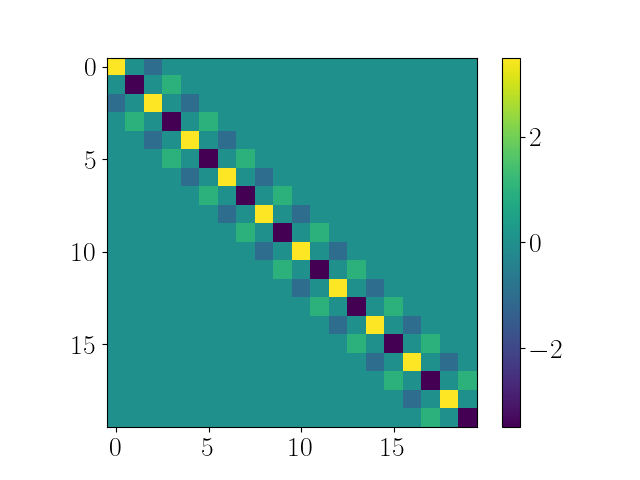

In [249]:
plt.figure()
plt.imshow(h_0(0))
plt.colorbar()

(40, 4)
(40, 4)
(40, 16)
(40, 16)


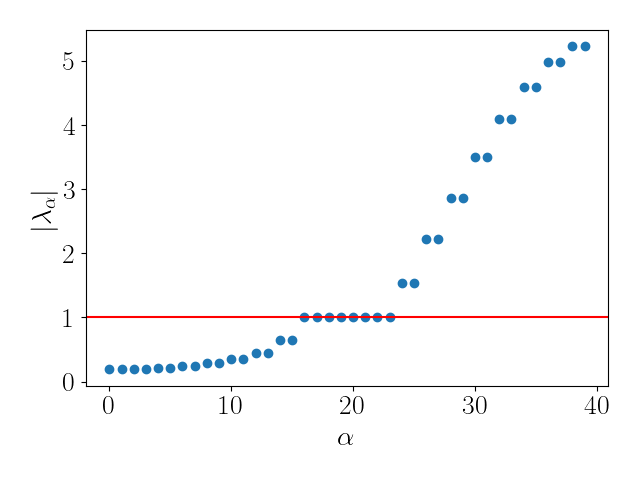

In [252]:
# Computing all the modes in the left lead at some energy E:
E = 1j*np.pi*(2*0 + 1)*1
# E = 0.0
slice = 0
M00 = -np.linalg.inv(T(slice , -1))@(E -  h_0(slice)) # <- Calculating the Hamiltonian at slice j = 0 , which is in the left lead.
M01 = -np.linalg.inv(T(slice , -1))@T(slice , +1)
M10 = np.identity(2*W)
M11 = np.zeros(shape = (2*W , 2*W))

M = np.block([[M00 , M01],[M10 , M11]]) #<- Matrix to diagonalise for propagating modes in lead
evals , evecs = np.linalg.eig(M)

def sorting_modes(eigenvalues , eigenvectors , tol = 1e-4):
    '''
    This function sorts modes into those that evanesce in the positive-x and negative-x directions
    and those that propagate in the +ve and -ve x direction.
    Inputs:
    eigenvalues: array_like, vector of eigenvalues.
    eigenvectors: ndarray , matrix of eigenvectors where columns 'i' to eigenvalue 'i'.
    tol: float , optional.  Tolerance to determine if eigenvalue is unit magnitude. If not set manually, default precision is 1e-4.
        WARNING: If tolerance is smaller than numerical precision, the function might "miss" all the propagating modes.
    Returns:
    pos_evanesce , neg_evanesce: ndarray, Eigenvectors that evanesce in the positive and negative x-direction respectively.
    pos_prop , neg_prop: ndarray, Eigenvectors that evanesce in the positive and negative x-direction respectively.
    list_of_eigenvalues:list, List of arrays [pos_p_evals , neg_p_evals , pos_e_evals , neg_e_evals] with eigenvalues sorted according to their propagation type.
    '''
    # Eigenvalues corresponding to states that decay in the positive x direction:
    pos_e_evals = eigenvalues[(np.abs(eigenvalues) - 1) < -tol]
    # Eigenvalues corresponding to states that evanesce in the negative x direction:
    neg_e_evals = eigenvalues[(np.abs(eigenvalues) - 1) > tol]
    # Eigenvalues corresponding to propagating states in the +ve x direction:
    propagatingstates = eigenvalues[np.abs((np.abs(eigenvalues) - 1)) <= tol]
    pos_p_evals = propagatingstates[np.angle(propagatingstates) > 0]
    # Eigenvalues corresponding to propagating states in the -ve x direction:
    neg_p_evals = propagatingstates[np.angle(propagatingstates) < 0]

    # Checking that the lengths of pos_e_evals , neg_e_evals , pos_p_evals , neg_p_evals sum up to len(evals)
    if (len(pos_e_evals) + len(pos_p_evals) + len(neg_e_evals) + len(neg_p_evals)) != len(evals):
        raise Exception("The number of evanescent and propagating states in the +ve and -ve x direction does not match the length of eigenvalues array. Change tolerance!")

    #Eigenvectors that evanesce in the positive x direction:
    pos_evanesce = eigenvectors[: , (np.abs(eigenvalues) - 1) < -tol]
    #Eigenvectors that evanesce in the negative x direction:
    neg_evanesce = eigenvectors[: , (np.abs(eigenvalues) - 1) > tol]
    #Eigenvectors that propagate in the positive x direction:
    propagatingeigenvectors = eigenvectors[: , np.abs((np.abs(eigenvalues) - 1)) < tol]
    pos_prop = propagatingeigenvectors[: , np.angle(propagatingstates) > 0]
    neg_prop = propagatingeigenvectors[: , np.angle(propagatingstates) < 0]
    
    list_of_eigenvalues= [pos_p_evals , neg_p_evals , pos_e_evals , neg_e_evals]
    
    return pos_prop , neg_prop , pos_evanesce , neg_evanesce , list_of_eigenvalues
    
pos_prop , neg_prop , pos_evanesce , neg_evanesce , list_of_eigenvalues = sorting_modes(evals , evecs  , tol = 1e-4)
print(np.shape(pos_prop))
print(np.shape(neg_prop))
print(np.shape(pos_evanesce))
print(np.shape(neg_evanesce))

fig , ax = plt.subplots()
ax.scatter(np.arange(len(evals)) , np.sort(np.abs(evals)))
ax.axhline(y = 1 , color = 'r')
ax.set_ylabel(r'$|\lambda_{\alpha}|$')
ax.set_xlabel(r'$\alpha$')
plt.tight_layout()

In [246]:
# First I am going to glue together all modes that evanesce/propagate in the positive x-direction:
pos_modes = np.hstack((pos_prop , pos_evanesce))
neg_modes = np.hstack((neg_prop , neg_evanesce))

# The U(\pm)-matrices consisten of amplitudes on the j = 0 slice. So we take only the first half rows:
U_pos = pos_modes[0:int(pos_modes.shape[0]/2) , :]
U_neg = neg_modes[0:int(neg_modes.shape[0]/2) , :]

# The \Lambda(\pm) matrix comprises of all the corresponding eigenvalues:
Lambda_pos = np.diag(np.hstack((list_of_eigenvalues[0] ,list_of_eigenvalues[2])))
Lambda_neg = np.diag(np.hstack((list_of_eigenvalues[1] , list_of_eigenvalues[3])))

# Construct the F(\pm) transfer matrices:
F_pos = U_pos @ Lambda_pos @ np.linalg.inv(U_pos)
F_neg = U_neg @ Lambda_neg @ np.linalg.inv(U_neg)


array([[ 0.05900432-0.07911746j,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        , -0.20532333-0.29189163j,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.  